In [86]:
%cd '/app'

/app


In [88]:
from sage.all import *
import itertools as it
from random import shuffle
import numpy as np
from copy import copy, deepcopy
from dataclasses import dataclass
from typing import List

import sys
sys.path.append('src')
from src.border_basis.plot import plot_order_ideals

In [10]:
def border(O, span_variables=None):
    if span_variables is None:
        span_variables = O[0].args()

    B = []
    for x in span_variables:
        B += [x*o for o in O if x*o not in O]
    return sorted(list(set(B)), key=lambda t: t)

def terms_up_to_degree(d: int, ring):
    """Compute all terms up to degree d."""
    n = ring.ngens()
    terms = [ring(1)]
    for t in range(1, d+1):
        exponents = list(WeightedIntegerVectors(t, [1]*n))
        terms.extend([ring.monomial(*e) for e in exponents])
        
    terms = sorted(terms, key=lambda t: t)
    return terms

def order_from_border(B, ring):
    max_deg = max([b.degree() for b in B])
    terms = terms_up_to_degree(max_deg, ring)
    O = []
    for t in terms:
        if any([t.divides(b) for b in B if t != b]):
            O.append(t)
            
    return O

def subs(F, P):
    '''
    F: list of polynomials
    P: list of points
    '''
    field = P[0, 0].base_ring()
    num_polys  = len(F)
    num_points = P.nrows()
    
    FP = [f(*p) for f in F for p in P]

    return MatrixSpace(field, num_points, num_polys)(FP)

def is_regular(M):
    r = min(M.ncols(), M.nrows())
    return M.rank() == r

def keyword_for_numbound(field, bound):
    if field == QQ:
        return {'num_bound': bound}
    if field == ZZ:
        return {'x': -bound, 'y': bound}
    if field == RR:
        return {'min': -bound, 'max': bound}
    if field.is_finite():
        return {}
    

def is_all_divisors_in(t: Polynomial, O) -> bool:
    """
    Check if adding term t to order ideal O maintains the order ideal property.
    
    Since O is already an order ideal, we only need to check immediate divisors
    (reducing degree by 1 for each variable).
    """
    if t.degree() in (0, 1): 
        return True
    
    return all([xi in O and t/xi in O for xi in t.args() if xi.divides(t)])


def is_order_ideal(O):
    max_deg = max([o.degree() for o in O])
    
    if 1 not in O:
        return False
    
    O_ = [1]
    for d in range(1, max_deg+1):
        terms = [o for o in O if o.degree() == d]
        for t in terms:
            if not is_all_divisors_in(t, O_):
                return False
        
        O_ += terms
    
    return True
    
    

In [32]:
@dataclass
class Segment:
    """Represents a segment in n-dimensional space defined by two endpoints and an axis"""
    endpoints: List        # List[np.ndarray], two endpoints (n-dim vector each)
    axis: int             # axis index for this segment
    
    def __post_init__(self):
        """Initialize bounds and dimension after instantiation"""
        self.lb = np.array(np.minimum.reduce(self.endpoints), dtype=int)
        self.ub = np.array(np.maximum.reduce(self.endpoints), dtype=int)
        self.n = len(self.lb)
    
    def __repr__(self):
        return f'Segment(lb={self.lb}, ub={self.ub}, endpoint={self.endpoints}, axis={self.axis})'

    def __hash__(self):
        return hash((tuple(self.lb), tuple(self.ub), self.axis))
    
    def sampling(self) -> np.ndarray:
        """Sample a point from the segment's interior, keeping axis coordinate fixed at maximum"""
        point = self.ub.copy()
        point[:self.axis] = np.random.randint(self.lb[:self.axis]+1, self.ub[:self.axis])
        point[self.axis+1:] = np.random.randint(self.lb[self.axis+1:]+1, self.ub[self.axis+1:])
        return point
    
    def random_extension(self, length_bound: int) -> 'Segment':
        """Extend the segment randomly within the given length bound"""
        endpoint = self.sampling()
        endpoint[self.axis] = np.random.randint(1, length_bound+1)
        return Segment(deepcopy([self.lb, endpoint]), self.axis)
        
    def is_extendable(self) -> bool:
        """Check if segment can be extended (difference >= 3 in non-axis dimensions)"""
        delta = np.abs(self.remove_axis(self.ub - self.lb))
        return all(delta >= 3)
    
    def remove_axis(self, v: np.ndarray) -> np.ndarray:
        """Remove axis dimension from vector"""
        return np.concatenate([v[:self.axis], v[self.axis+1:]])

@dataclass
class NeighborSegments:
    """Collection of segments that intersect at a point"""
    segments: List[Segment]
    intersecting_point: np.ndarray
    
    def __post_init__(self):
        """Initialize dimension, max point and validity after instantiation"""
        self.n = self.segments[0].n
        max_point = np.vstack([segment.ub for segment in self.segments])
        self.max_point = np.min(max_point + np.eye(self.n, dtype=int) * 100000, axis=0)
        self.valid = not np.any((self.max_point - self.intersecting_point) <= 1)
    
    def sampling(self) -> np.ndarray:
        """Sample a point between intersecting_point and max_point"""
        degenerated = np.array(self.intersecting_point + 1 >= self.max_point, dtype=int)
        point = np.random.randint(self.intersecting_point + 1, 
                                self.max_point + degenerated)
        return point
    
    def split_at(self, splitpoint: np.ndarray) -> List['NeighborSegments']:
        """Split segments at given point to create new NeighborSegments"""
        new_neighborsegments = []
        for i in range(self.n):
            segment_i = Segment(deepcopy([self.intersecting_point, splitpoint]), i)
            new_segments = self.segments[:i] + [segment_i] + self.segments[i+1:]
            new_intersecting_point = (self.intersecting_point + 
                                    np.eye(self.n)[i] * splitpoint[i])
            new_neighborsegment = NeighborSegments(deepcopy(new_segments), 
                                                 new_intersecting_point)
            new_neighborsegments.append(new_neighborsegment)
        return new_neighborsegments

In [80]:
import itertools as it
from random import shuffle
import numpy as np
from copy import copy, deepcopy
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional, Any, Union

def is_on_axis(v: np.ndarray) -> bool:
    """
    Checks if vector v has at most one non-zero coordinate
    
    Parameters:
    -----------
    v : np.ndarray
        Input vector
        
    Returns:
    --------
    bool
        True if v has at most one non-zero coordinate
    """
    return np.sum(v != 0) <= 1

class BorderBasisGenerator:
    def __init__(self, ring): 
        """
        Initialize generator for computing border bases
        
        Parameters:
        -----------
        ring : Ring
            Ring object that defines the polynomial ring and number of variables
        """
        self.ring = ring 
        self.n = ring.ngens()
    
    def sample_order_ideal(self, degree_bounds: List[int], 
                   max_iters: int = 100) -> List[Tuple[int, ...]]:
        """
        Generates border by iteratively splitting segments and sampling points
        
        Parameters:
        -----------
        degree_bounds : List[int]
            Maximum degree for each variable. Length must equal self.n
        max_iters : int
            Maximum number of iterations for segment splitting
            
        Returns:
        --------
        List[Tuple[int, ...]]
            List of points forming the order ideal, sorted lexicographically
        """
        
        origin = np.zeros(self.n, dtype=int)
        max_point = np.array(degree_bounds)
        
        S = []
        for i in range(self.n):
            endpoint = max_point.copy()
            endpoint[i]= 0
            segment = Segment([origin, endpoint], i)
            S.append(segment)
            
        N = [NeighborSegments(deepcopy(S), origin)]
        T = []
        O = []
        
        for i in range(max_iters):
            if i == max_iters - 1:
                print(f'Failed to find a border after {max_iters} iterations.')
                break
            # if not N:
                # print(f'No segments left to extend after {i} iterations.')
                # break
            
            neighbor_segment = N.pop()
            new_neighborsegments = []
            splitpoint = neighbor_segment.sampling()
            
            if i == 0:
                O.extend(deepcopy(self.hypercube_points(origin, splitpoint, exclude_max=True)))
                
            for new_neighborsegment in neighbor_segment.split_at(splitpoint):
                if new_neighborsegment.valid:
                    new_neighborsegments.append(new_neighborsegment)
                T.append(new_neighborsegment)
                    
            N.extend(new_neighborsegments)
            shuffle(N)

        for neighbor_segment in T:
            u = neighbor_segment.intersecting_point
            v = neighbor_segment.max_point
            points = self.hypercube_points(u, v, exclude_max=True)
            O.extend(deepcopy(points))

        return list(set(O))
        

    def hypercube_points(self, u: np.ndarray, v: np.ndarray, 
                        exclude_max: bool = True) -> List[Tuple[int, ...]]:
        """
        Generate all integer points in hypercube [u,v]
        
        Parameters:
        -----------
        u, v : np.ndarray
            Lower and upper bounds defining the hypercube
        exclude_max : bool
            Whether to exclude the maximum point v
            
        Returns:
        --------
        List[Tuple[int, ...]]
            All grid points in hypercube, excluding v if specified
        """
        u = np.minimum(u, v)
        v = np.maximum(u, v)
        n = len(u)
        grid_ranges = [np.arange(u[i], v[i] + 1) for i in range(n)]
        points = [tuple(np.array(p)) for p in it.product(*grid_ranges) 
                 if not (exclude_max and np.array_equal(p, v))]
        return points

    def random_order_ideal(self, degree_bounds: List[int], **kwargs) -> List[Tuple[int, ...]]:
        """
        Generate random border with random bounds up to given maximum
        
        Parameters:
        -----------
        degree_bounds : List[int]
            Maximum possible degree for each variable
        **kwargs : 
            Additional arguments passed to find_border
        
        Returns:
        --------
        List[Tuple[int, ...]]
            Randomly generated border points
        """
        upper_bounds = np.random.randint(1, np.array(degree_bounds)+1)
        return self.sample_order_ideal(upper_bounds, **kwargs)
    
    def compute_border_basis(self, B: List[Any], O: List[Any], P: Any) -> Tuple[Optional[List], bool]:
        """
        Find a border basis for given border B and order ideal O at points P
        
        Parameters:
        -----------
        B : List[Any]
            List of border terms (as ring elements)
        O : List[Any]
            List of order ideal terms (as ring elements)
        P : Any
            Matrix of evaluation points
        
        Returns:
        --------
        Tuple[Optional[List], bool]
            - First element is the basis coefficients if found, None if not found
            - Second element is True if basis was found successfully
        """
        ring = self.ring
        O = [ring(o) for o in O]
        OP = subs(O, P)
        
        if not is_regular(OP):
            print('The matrix is not regular.')
            return None, False
        
        B = [ring(b) for b in B]
        BP = subs(B, P)
        M = BP.augment(OP)
        V = M.transpose().kernel().basis()
        
        return V, True
    
    def random_border_basis(self, degree_bounds: List[int], 
                          max_sampling: int = 100,
                          degree_lower_bound: Optional[List[int]] = None, 
                          **kwargs) -> Dict[str, Any]:
        """
        Generate a random border basis with given degree bounds
        
        Parameters:
        -----------
        degree_bounds : List[int]
            Maximum degree for each variable
        max_sampling : int
            Maximum number of attempts to find valid evaluation points
        degree_lower_bound : Optional[List[int]]
            Minimum degree for each variable (defaults to [0,...,0])
        **kwargs : 
            Additional arguments passed to find_border
        
        Returns:
        --------
        Dict[str, Any] with keys:
            - basis: List of basis elements
            - order_coeff: Coefficients of the border basis
            - border: Border terms
            - order: Order ideal terms
            - points: Evaluation points
            - success: Whether computation succeeded
        """
        assert len(degree_bounds) == self.n
        
        if degree_lower_bound is None:
            degree_lower_bound = [0] * self.n
        
        # Generate random border and convert to polynomial ring
        ring = self.ring
        O = self.random_order_ideal(degree_bounds)
        # plot_border(degree_bounds, O)
        O = [ring.monomial(*o) for o in O]
        B = border(O)
        
        # Find basis by sampling points
        MSpace = MatrixSpace(ring.base_ring(), len(O), self.n)
        success = False
        
        for i in range(max_sampling):
            if i == max_sampling - 1:
                print(f'Failed to find a border basis after {max_sampling} sampling of points.')
                break
                
            P = MSpace.random_element(**keyword_for_numbound(ring.base_ring(), 10))
            V, success = self.compute_border_basis(B, O, P)
            
            if success:
                break
        
        # Construct border basis
        G = []
        for i in range(len(V)):
            g = B[i] - sum([v * o for v, o in zip(V[i][len(B):], O)])
            G.append(g)
        
        return {
            'basis': G,
            'order_coeff': V, 
            'border': B,
            'order': O,
            'points': P,
            'success': success
        }

In [ ]:
%time
# seed = 1
# np.random.seed(seed)
# import random
# random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [10, 5, 5]
O = generator.sample_order_ideal(dbounds)

print(is_order_ideal([ring.monomial(*o) for o in O]))
print()
print('random border')
print(O)
# plot_border_3d(dbounds, B)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 23.4 µs


AttributeError: 'BorderBasisGenerator' object has no attribute 'sample_order_ideal_2d'

Upper bounds: [ 5 10  1]
No segments left to extend after 1 iterations.
Upper bounds: [1 7 3]
No segments left to extend after 1 iterations.
Upper bounds: [4 3 3]
No segments left to extend after 1 iterations.
Upper bounds: [7 1 2]
No segments left to extend after 1 iterations.
Upper bounds: [9 5 2]
No segments left to extend after 1 iterations.


Upper bounds: [8 9 2]
No segments left to extend after 1 iterations.
Upper bounds: [4 9 3]
No segments left to extend after 2 iterations.
Upper bounds: [10  1  1]
No segments left to extend after 1 iterations.
Upper bounds: [8 7 3]
No segments left to extend after 2 iterations.
Upper bounds: [9 7 3]
No segments left to extend after 2 iterations.


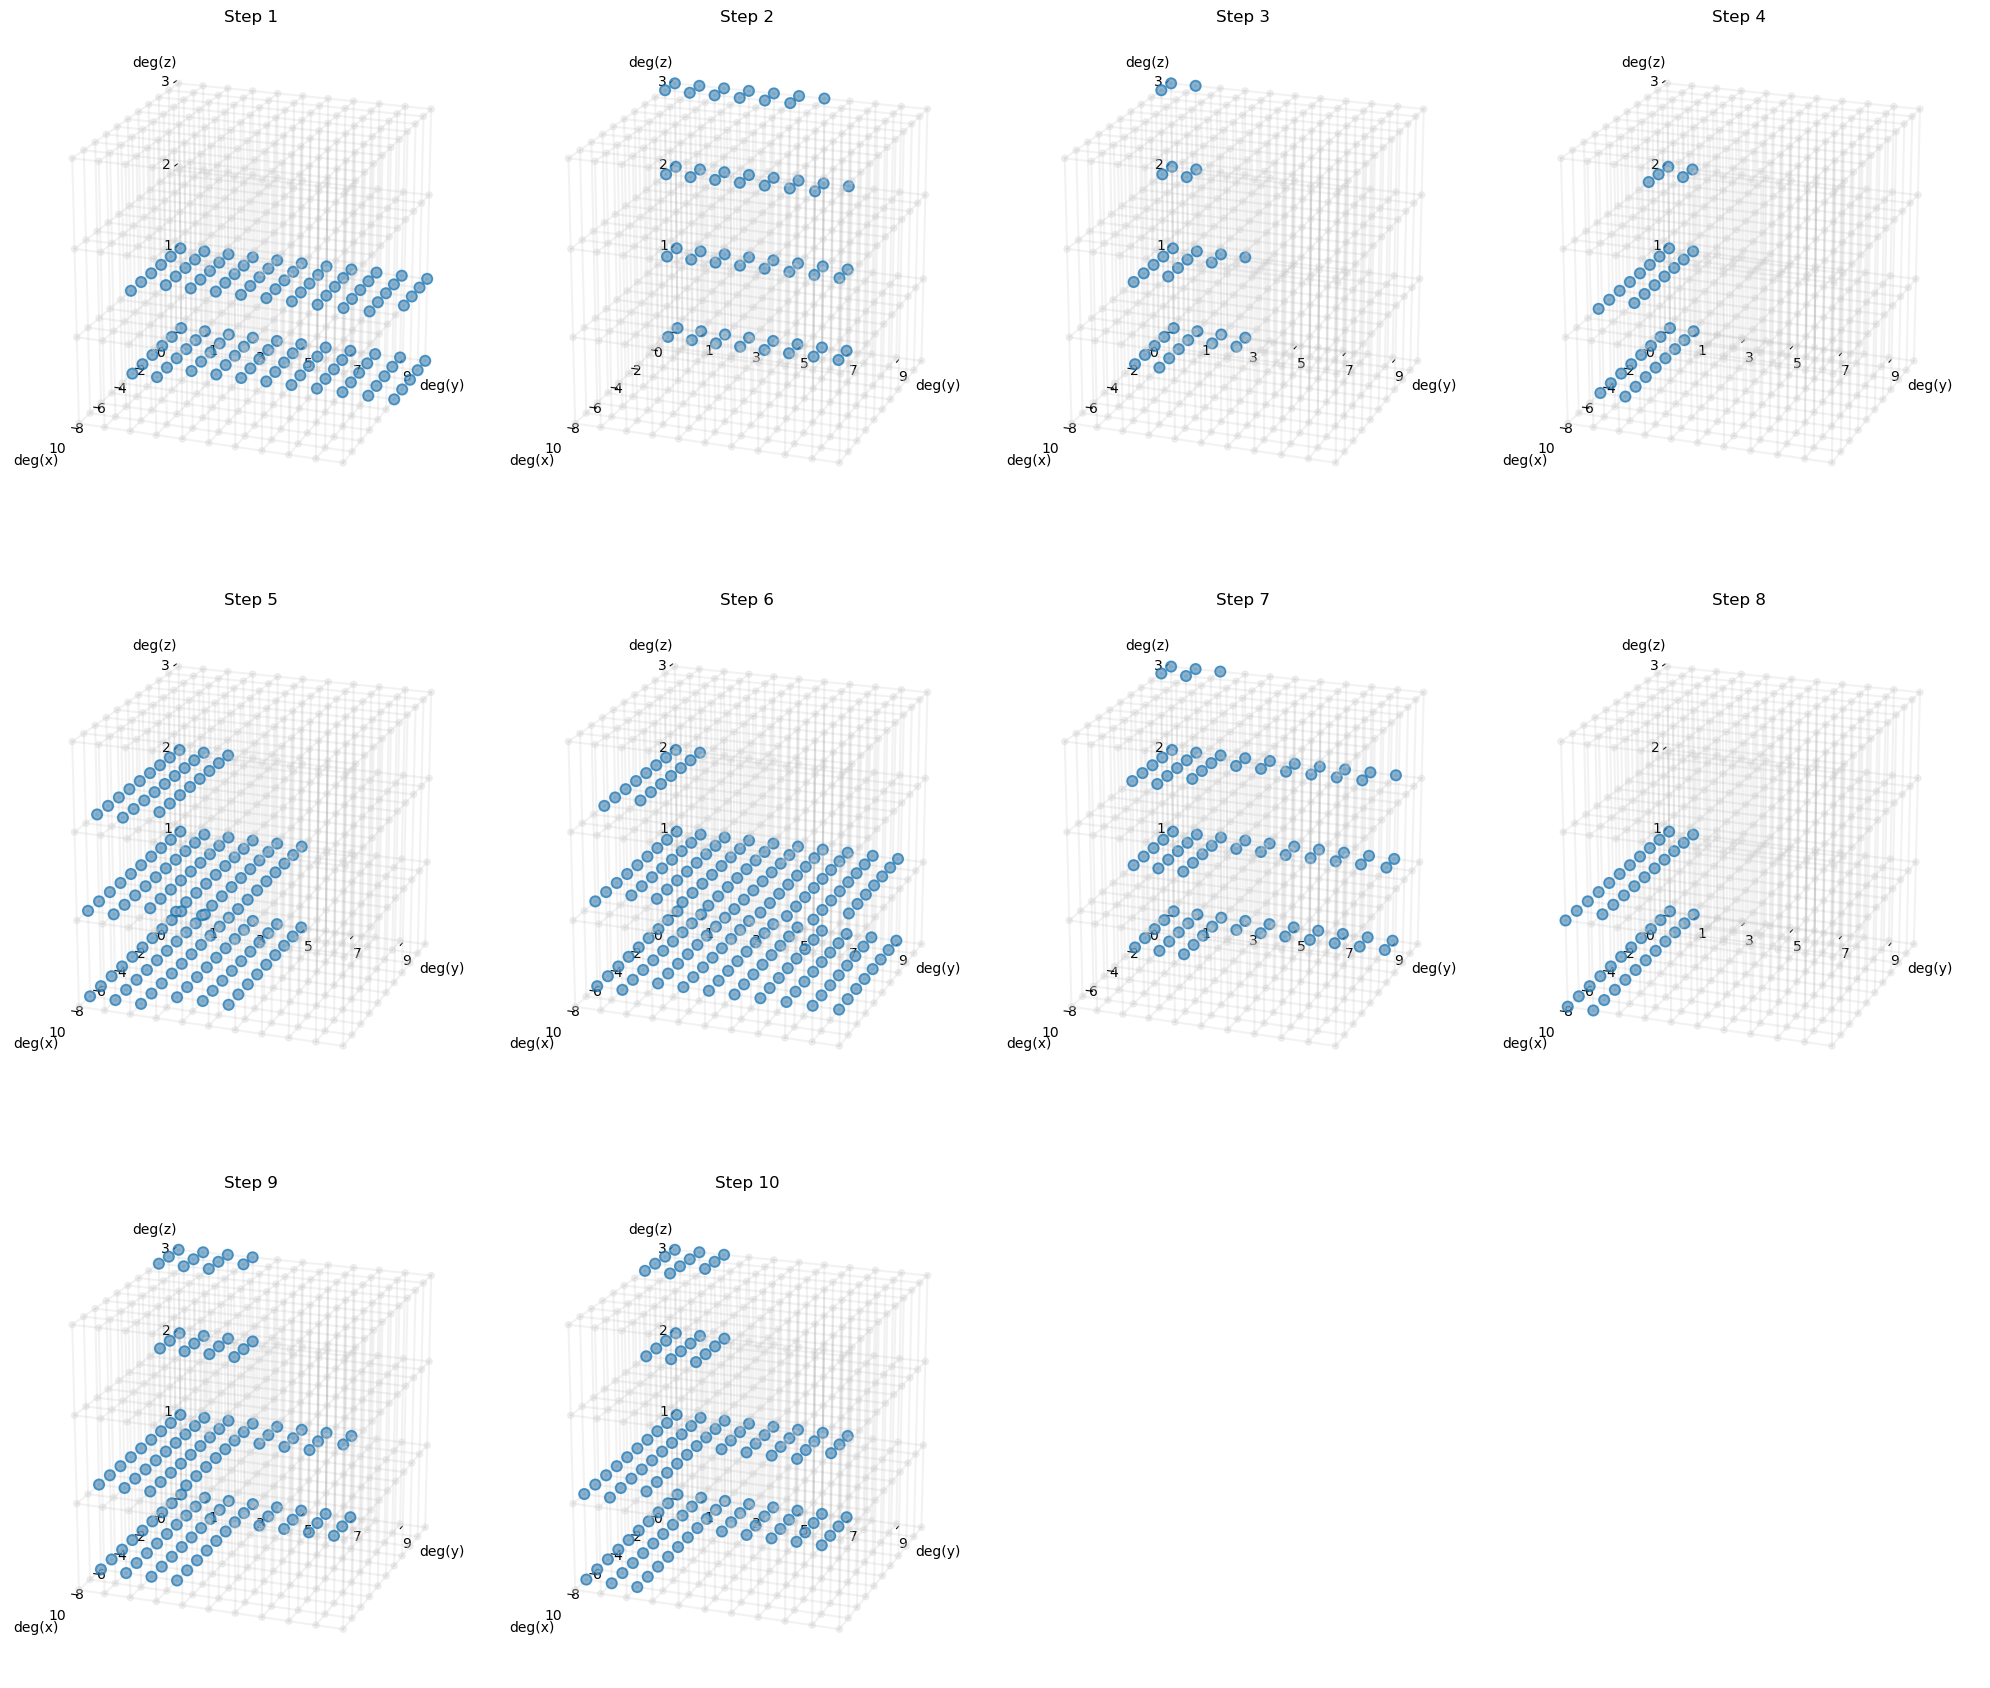

In [79]:
ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [10, 10, 3]
Os = []
for i in range(10):
    O = generator.random_order_ideal(dbounds)

    assert(is_order_ideal([ring.monomial(*o) for o in O]))
    Os.append(O)
    
plot_order_ideals_3d(dbounds, Os)

In [290]:
print(is_order_ideal([ring.monomial(*b) for b in B]))

True


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.8 µs
No segments left to extend after 1 iterations.

random border
[(0, 1), (4.0, 0.0), (2.0, 1.0), (0, 0), (3.0, 1.0), (1, 1), (2, 0), (3.0, 0.0), (5.0, 0.0), (1, 0), (4.0, 1.0)]


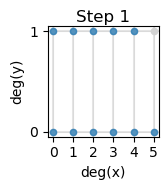

In [27]:
%time
# seed = 1
# np.random.seed(seed)
# import random
# random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [5, 1]
B = generator.find_border(dbounds)

print()
print('random border')
print(B)
plot_border(dbounds, B)

Upper bounds: [2 1]
No segments left to extend after 1 iterations.


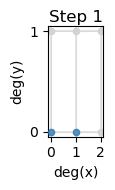

{'basis': [-50*x + y + 65, x*y - 43*x + 59, x^2 - 47*x + 56],
 'order_coeff': [
 (1, 0, 0, 50, -65),
 (0, 1, 0, 43, -59),
 (0, 0, 1, 47, -56)
 ],
 'border': [y, x*y, x^2],
 'order': [x, 1],
 'points': [ 4 -5]
 [ 3  5],
 'success': True}

In [237]:
generator.random_border_basis(dbounds, max_sampling=100)

In [120]:
is_order_ideal([ring.monomial(*b) for b in B])

True

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.4 µs
No segments left to extend after 1 iterations.

random border
[(1.0, 1.0, 0.0), (0.0, 1.0, 0.0), (0, 0, 0), (1.0, 0.0, 0.0), (2.0, 0.0, 0.0), (0.0, 0.0, 1.0)]


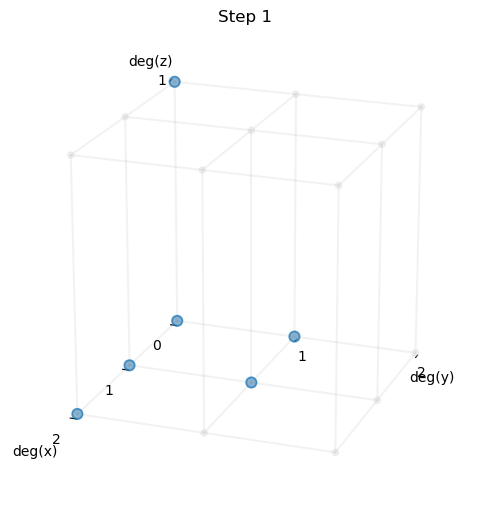

In [241]:
%time
# seed = 1
# np.random.seed(seed)
# import random
# random.seed(seed)

ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [2, 2, 1]
B = generator.find_border(dbounds)

print()
print('random border')
print(B)
plot_border_3d(dbounds, B)

segment picekd up: Segment(lb=[0 0 0], ub=[2 2 2], endpoint=[array([2, 0, 0]), array([0, 2, 0]), array([0, 0, 2])])
new endpoint: [2 1 2]
new segments:
Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 2])])
--- accepted!
Segment(lb=[0 1 0], ub=[2 2 2], endpoint=[array([2, 1, 0]), array([0, 2, 0]), array([0, 1, 2])])
--- accepted!
Segment(lb=[0 0 2], ub=[2 1 2], endpoint=[array([2, 0, 2]), array([0, 1, 2]), array([0, 0, 2])])
--- accepted!
segment picekd up: Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 2])])
--- rejected! [2 0 0]
new endpoint: [2 1 0]
new segments:
Segment(lb=[2 0 0], ub=[2 1 0], endpoint=[array([2, 0, 0]), array([2, 1, 0]), array([2, 0, 0])])
--- rejected! degenerated
--- rejected! on the same street
Segment(lb=[2 1 0], ub=[2 1 0], endpoint=[array([2, 1, 0]), array([2, 1, 0]), array([2, 1, 0])])
--- rejected! degenerated
Segment(lb=[2 0 0], ub=[2 1 2], endpoint=[array([2, 0, 0]), ar

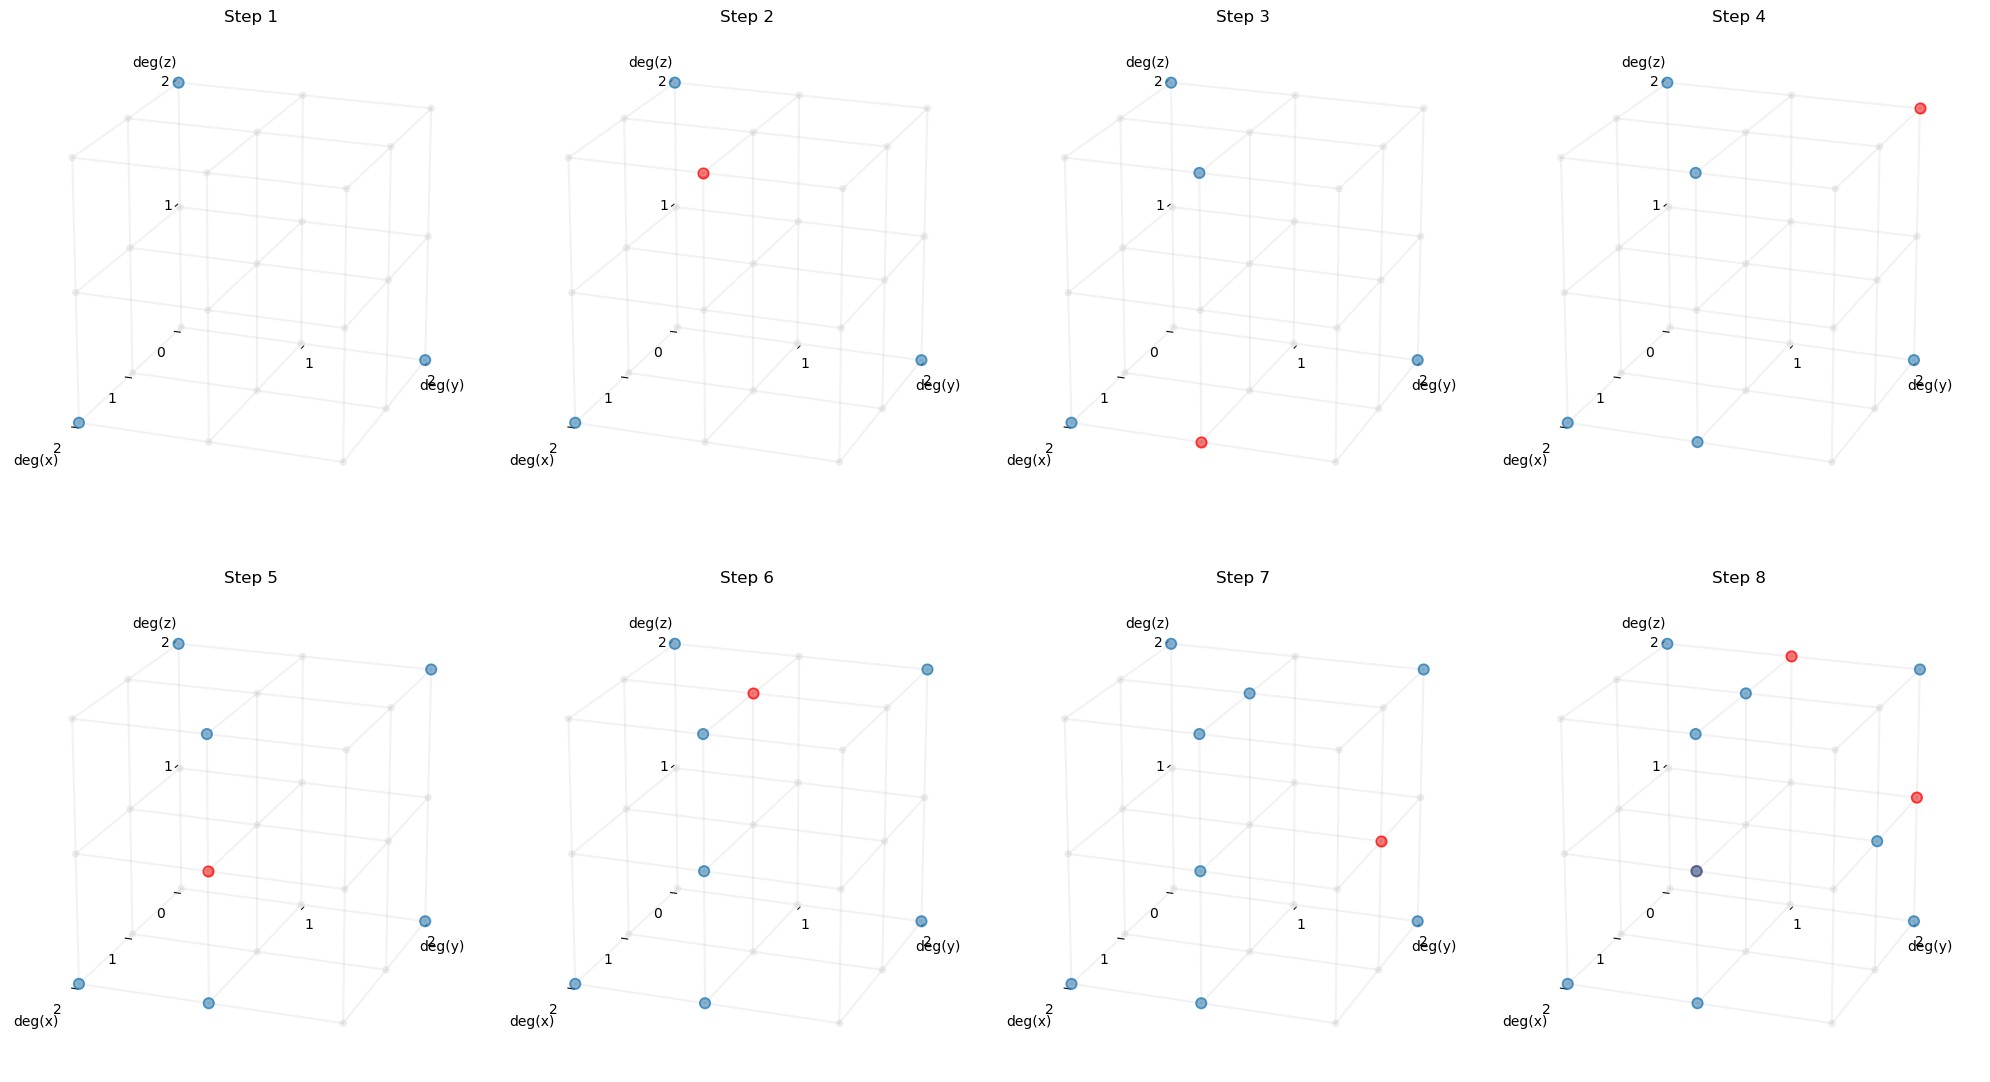

In [22]:
# fix random seed
seed = 5
np.random.seed(seed)
import random
random.seed(seed)


ring = PolynomialRing(QQ, ('x', 'y', 'z'), order='degrevlex')
generator = BorderBasisGenerator(ring)

dbounds = [2, 2, 2]
ret = generator.find_random_preborder(dbounds, max_iters=20)
Bs = ret['trajectory']
B = generator.close_border(Bs[-1])
Bs.append(B)
# # plot_borders(dbounds, Bs)
O = order_from_border([ring.monomial(*e) for e in B], ring)
# print(O)
plot_borders_3d(dbounds, Bs)

In [54]:
ret['segments']

[[array([2, 2, 1]), array([2, 0, 2]), array([1, 0, 1])],
 [array([2, 2, 0]), array([1, 2, 0]), array([2, 2, 2])],
 [array([2, 2, 1]), array([2, 0, 1]), array([0, 1, 1])],
 [array([1, 1, 2]), array([2, 1, 1]), array([0, 1, 2])],
 [array([2, 0, 0]), array([0, 0, 2]), array([2, 1, 1])],
 [array([2, 0, 0]), array([2, 2, 1]), array([2, 1, 2])],
 [array([1, 1, 2]), array([2, 2, 2]), array([2, 1, 0])],
 [array([0, 0, 2]), array([2, 1, 1]), array([0, 1, 2])],
 [array([2, 2, 1]), array([1, 0, 1]), array([1, 0, 2])],
 [array([2, 0, 0]), array([2, 0, 2]), array([2, 1, 2])],
 [array([0, 2, 0]), array([1, 1, 2]), array([1, 2, 2])],
 [array([0, 2, 0]), array([2, 0, 1]), array([0, 1, 1])],
 [array([1, 1, 2]), array([2, 2, 1]), array([1, 0, 2])],
 [array([1, 2, 0]), array([2, 2, 2]), array([2, 1, 0])],
 [array([1, 1, 2]), array([1, 2, 0]), array([2, 1, 0])],
 [array([2, 0, 0]), array([0, 2, 0]), array([2, 0, 1])]]

In [ ]:
import matplotlib.pyplot as plt
import math
from typing import List, Tuple, Optional

def plot_order_ideals_2d(degree_bounds: List[int], 
                     order_ideals: List[List[Tuple[int, int]]], 
                     filename: Optional[str] = None,
                     track_changes: bool = False):
    """
    Plot multiple order ideals in a grid layout
    
    Parameters:
    -----------
    degree_bounds : List[int]
        Maximum degree for each variable [deg(x), deg(y)]
    order_ideals : List[List[Tuple[int, int]]]
        List of order ideals to plot
    filename : Optional[str]
        If provided, save plot to this file
    track_changes : bool
        If True, highlight new points in each step with red color
    """
    aspect_ratio = 1
    n_plots = len(order_ideals)
    n_cols = int(min(5 / aspect_ratio, n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    
    fig = plt.figure(figsize=(4*n_cols, 2*n_rows))
    
    base_color = '#1f77b4'  # Steel blue
    new_point_color = '#d62728'  # Red
    
    for idx, order_ideal in enumerate(order_ideals):
        ax = fig.add_subplot(n_rows, n_cols, idx+1)
        
        # Plot all possible grid points
        points = [(i,j) for i in range(degree_bounds[0] + 1) 
                 for j in range(degree_bounds[1] + 1)]
        x_coords, y_coords = zip(*points)
        ax.scatter(x_coords, y_coords, c='lightgray', s=20, zorder=2)
        
        # Plot order ideal points
        order_ideal_x, order_ideal_y = zip(*order_ideal)
        
        if track_changes and idx > 0:
            # Split points into existing and new
            prev_points = set(order_ideals[idx-1])
            current_points = set(order_ideal)
            new_points = current_points - prev_points
            
            # Plot existing points in blue
            existing_points = [(x, y) for x, y in order_ideal if (x, y) not in new_points]
            if existing_points:
                ex_x, ex_y = zip(*existing_points)
                ax.scatter(ex_x, ex_y, c=base_color, s=20, alpha=0.7, zorder=3, 
                          label='Existing points')
            
            # Plot new points in red
            if new_points:
                new_x, new_y = zip(*new_points)
                ax.scatter(new_x, new_y, c=new_point_color, s=20, alpha=0.7, zorder=4,
                          label='New points')
                ax.legend(loc='upper right', fontsize='small')
        else:
            # Plot all points in blue
            ax.scatter(order_ideal_x, order_ideal_y, c=base_color, s=20, 
                      alpha=0.7, zorder=3)
        
        # Add grid lines
        for i in range(degree_bounds[0] + 1):
            ax.axvline(i, color='gray', alpha=0.2, zorder=1)
        for i in range(degree_bounds[1] + 1):
            ax.axhline(i, color='gray', alpha=0.2, zorder=1)
        
        # Set ticks and labels
        xticks = range(0, degree_bounds[0] + 1, max(1, degree_bounds[0] // 4))
        yticks = range(0, degree_bounds[1] + 1, max(1, degree_bounds[1] // 4))
        
        ax.set_xlabel('deg(x)')
        ax.set_ylabel('deg(y)')
        ax.grid(True, alpha=0.2, zorder=1)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_title(f'Step {idx+1}', pad=3)
        ax.set_box_aspect(aspect_ratio)
        
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_order_ideal_2d(degree_bounds: List[int], 
                    order_ideal: List[Tuple[int, int]], 
                    filename: Optional[str] = None):
    """
    Plot a single order ideal
    
    Parameters:
    -----------
    degree_bounds : List[int]
        Maximum degree for each variable [deg(x), deg(y)]
    order_ideal : List[Tuple[int, int]]
        Order ideal to plot
    filename : Optional[str]
        If provided, save plot to this file
    """
    plot_order_ideals_2d(degree_bounds, [order_ideal], filename)

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import numpy as np
from typing import List, Tuple, Optional

def plot_order_ideals_3d(degree_bounds: List[int], 
                        order_ideals: List[List[Tuple[int, int, int]]], 
                        filename: Optional[str] = None,
                        track_changes: bool = False):
    """
    Plot multiple 3D order ideals in a grid layout
    
    Parameters:
    -----------
    degree_bounds : List[int]
        Maximum degree for each variable [deg(x), deg(y), deg(z)]
    order_ideals : List[List[Tuple[int, int, int]]]
        List of order ideals to plot
    filename : Optional[str]
        If provided, save plot to this file
    track_changes : bool
        If True, highlight new points in each step with red color
    """
    n_plots = len(order_ideals)
    n_cols = int(min(4, n_plots))
    n_rows = math.ceil(n_plots / n_cols)
    
    fig = plt.figure(figsize=(5*n_cols, 6*n_rows))
    
    base_color = '#1f77b4'  # Steel blue
    new_point_color = '#d62728'  # Red
    
    for idx, order_ideal in enumerate(order_ideals):
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # Add grid lines
        for i in range(degree_bounds[0] + 1):
            for j in range(degree_bounds[1] + 1):
                ax.plot([i, i], [j, j], [0, degree_bounds[2]], 
                       'gray', alpha=0.1)  # Vertical lines
        
        for i in range(degree_bounds[0] + 1):
            for k in range(degree_bounds[2] + 1):
                ax.plot([i, i], [0, degree_bounds[1]], [k, k], 
                       'gray', alpha=0.1)  # Y-direction lines
        
        for j in range(degree_bounds[1] + 1):
            for k in range(degree_bounds[2] + 1):
                ax.plot([0, degree_bounds[0]], [j, j], [k, k], 
                       'gray', alpha=0.1)  # X-direction lines
        
        # Plot all possible grid points
        points = [(i,j,k) for i in range(degree_bounds[0] + 1) 
                         for j in range(degree_bounds[1] + 1)
                         for k in range(degree_bounds[2] + 1)]
        if points:
            x_coords, y_coords, z_coords = zip(*points)
            ax.scatter(x_coords, y_coords, z_coords, c='lightgray', 
                      s=20, alpha=0.3, zorder=1)
        
        # Plot order ideal points
        order_ideal_x, order_ideal_y, order_ideal_z = zip(*order_ideal)
        
        if track_changes and idx > 0:
            # Split points into existing and new
            prev_points = set(order_ideals[idx-1])
            current_points = set(order_ideal)
            new_points = current_points - prev_points
            
            # Plot existing points in blue
            existing_points = [(x, y, z) for x, y, z in order_ideal 
                             if (x, y, z) not in new_points]
            if existing_points:
                ex_x, ex_y, ex_z = zip(*existing_points)
                ax.scatter(ex_x, ex_y, ex_z, c=base_color, s=60, alpha=0.7,
                          zorder=2, label='Existing points')
            
            # Plot new points in red
            if new_points:
                new_x, new_y, new_z = zip(*new_points)
                ax.scatter(new_x, new_y, new_z, c=new_point_color, s=60,
                          alpha=0.7, zorder=3, label='New points')
                ax.legend(loc='upper right', fontsize='small')
        else:
            # Plot all points in blue
            ax.scatter(order_ideal_x, order_ideal_y, order_ideal_z,
                      c=base_color, s=60, alpha=0.7, zorder=2)
        
        # Set labels and ticks
        ax.zaxis.set_rotate_label(False)
        ax.set_xlabel('deg(x)')
        ax.set_ylabel('deg(y)')
        ax.set_zlabel('deg(z)', rotation=0)
        
        # Set tick marks
        xticks = range(0, degree_bounds[0] + 1, max(1, degree_bounds[0] // 4))
        yticks = range(1, degree_bounds[1] + 1, max(1, degree_bounds[1] // 4))
        zticks = range(1, degree_bounds[2] + 1, max(1, degree_bounds[2] // 4))
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_zticks(zticks)
        
        ax.set_title(f'Step {idx+1}')
        ax.set_box_aspect([1,1,1])
        
        # Remove grid and background
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        # Set view angle
        ax.view_init(elev=20, azim=20)
        
        # Set axis limits
        ax.set_xlim(0, degree_bounds[0])
        ax.set_ylim(0, degree_bounds[1])
        ax.set_zlim(0, degree_bounds[2])
        
        # Fix axis juggling
        ax.xaxis._axinfo['juggled'] = (0,0,0)
        ax.yaxis._axinfo['juggled'] = (1,1,1)
        ax.zaxis._axinfo['juggled'] = (2,2,2)

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_order_ideal_3d(degree_bounds: List[int], 
                       order_ideal: List[Tuple[int, int, int]], 
                       filename: Optional[str] = None):
    """
    Plot a single 3D order ideal
    
    Parameters:
    -----------
    degree_bounds : List[int]
        Maximum degree for each variable [deg(x), deg(y), deg(z)]
    order_ideal : List[Tuple[int, int, int]]
        Order ideal to plot
    filename : Optional[str]
        If provided, save plot to this file
    """
    plot_order_ideals_3d(degree_bounds, [order_ideal], filename)

In [23]:
OP

NameError: name 'OP' is not defined

In [172]:
BP

[ 125   -8  1/8    8]
[   1    1  -25  -16]
[   0  -16 -1/2    1]
[   5  -32    0   32]
[ 1/4    1   -1  -64]
[   0  -64 -1/8    1]

In [84]:
# get random matrix with entries in ring.base_ring() and ranging from -5 ,5 
M = random_matrix(ring.base_ring(), 3, 3, x=-5, y=5)

TypeError: randomize() got an unexpected keyword argument 'x'

In [ ]:
import numpy as np
# P = np.random.randint(-5, 5, (len(O), 2))

FP = subs(O, P)
is_regular(FP)

True

In [76]:
BP = subs(B, P)
C = np.linalg.lstsq(FP, BP, rcond=None)[0]
C.shape

(6, 4)

In [ ]:
np.linalg.norm(BP - FP @ C)

5.352483649338326e-13